In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [2]:
from scipy import stats

In [3]:
from tqdm.auto import tqdm

In [4]:
import itertools
import json
import random
from glob import glob
from pathlib import Path

In [5]:
# You will want to replace this
DATA_DIR = Path("../data/")

In [6]:
from storysniffer import StorySniffer
sniffer = StorySniffer()

def news_filter(row_tup):
    if len(row_tup.clean_text) > 200 or len(row_tup.clean_text) > (len(row_tup.all_text) + 2):
        return False
    if not sniffer.guess(row_tup.href):
        return False
    return True

/home/naitian/news-homepages/.pixi/envs/default/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/naitian/news-homepages/.pixi/envs/default/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/naitian/news-homepages/.pixi/envs/default/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to 

In [7]:
def read_ranking(ranking_file: Path) -> pd.DataFrame:
    # nytimes-position_and_size-outlet_cnet.json
    decider, _, listname = ranking_file.stem.split("-")
    articles = json.load(open(ranking_file))
    df = pd.DataFrame(articles).dropna(subset=["href"])
    df = df[[news_filter(r) for r in df.itertuples()]]
    df.loc[:, "article_rank"] = range(len(df))
    df.loc[:, "article_idx"] = df.all_text.rank()
    df.loc[:, "decider"] = decider
    df.loc[:, "list_name"] = listname
    df.loc[:, "list_type"] = listname.split("_")[0]
    df = df.sort_values(by="article_idx")
    return df

In [8]:
all_rankings = pd.concat([read_ranking(Path(path)) for path in glob(str(DATA_DIR / "homepage_clean_text-newlists-ranking-distilbert-base-uncased/*-multivariable/*-position_and_size-*.json"))])


In [9]:
all_rankings = all_rankings.sort_values(["list_name", "article_idx"])

In [10]:
def print_top_bottom(outlet, ref=None):
    if ref is None:
        ref = outlet
    print("top")
    rankings = all_rankings[all_rankings.decider.eq(outlet) & all_rankings.list_name.eq(f"outlet_{ref}")]
    for i in rankings.sort_values(by="article_rank", ascending=True)["clean_text"][:10].str.strip():
        print(i)
    print()
    print("bottom")
    for i in rankings.sort_values(by="article_rank", ascending=False)["clean_text"][:10].str.strip():
        print(i)

In [11]:
print_top_bottom("breitbartnews", "nytimes")

top
Phil Murphy Expands African American Studies, Knocking Ron DeSantis.
Michael Wolff Performs an Autopsy on Fox News.
Colombian Air Force
    ```
A New Battle in the War on Abortion Pills.
Philip Sherman, Who Circumcised Thousands of Babies, Dies at 67.
Critic’s Pick Step inside an artist’s wounded heart.
Paul Krugman: A.I. May Change Everything, but Probably Not Too Quickly.
Stymied by Congress, Biden Seeks to Rally Voters on Abortion A year after the end of Roe v. Wade, President Biden is working with a limited set of tools to galvanize supporters on abortion rights.
God Have Mercy, We Ask. Then We Must Act.
Paul Krugman None Dare Call it Victory.

bottom
According to TikTok, Americans Are Very, Very Thirsty. Social media grumbles that drinking water is hard to find in Europe.
Yellowstone, TV’s Hit Western, Will End Its Run After This Season.
He Made His Country Rich, but Something Has Gone Wrong With the System.
Drones struck a building in Moscow for the second time in two days.
4

In [12]:
print_top_bottom("nytimes", "nytimes")

top
Stymied by Congress, Biden Seeks to Rally Voters on Abortion A year after the end of Roe v. Wade, President Biden is working with a limited set of tools to galvanize supporters on abortion rights.
Framing Is Expensive. Online Framing Services Might Be Your Best Bet. The results look nicer than off-the-rack frames and generally cost less than the work of custom shops.
John Mellencamp Just Might Punch You The irascible rocker, now 71, reflects on how America plays into his music, his relationship to his biggest hits and his latest album, “Orpheus Descending.”
The Female Artisans Honoring, and Reinventing, Japanese Noh Masks In taking on the male-dominated theatrical craft, contemporary women carvers are changing the face of a centuries-old tradition.
The Best Movies and Shows on Hulu 
    ‘Unrest’ Review: The Times Are Not A-Changin’
A New Battle in the War on Abortion Pills.
A Ukrainian Orchestra’s Mission On tour, the Lviv National Philharmonic Orchestra shares the country’s cultur

In [13]:
deciders = list(all_rankings.decider.unique())
deciders.sort()

lists = list(all_rankings.list_name.unique())
lists.sort()

In [14]:
raw_groups = {
    "center": ["nytimes", "wsj", "washingtonpost"],
    "Right wing": ["breitbartnews", "bulwarkonline", "foxnews"],
    "Left wing": [
        "democracynow",
        "motherjones",
        "slate",
    ],
    "Local news": [
        "sfchronicle",
        "jaxdotcom",
        "seattletimes",
        "denverpost",
        "newsobserver",
        "startelegram",
    ],
    "tech": [
        "wired",
        "arstechnica",
        "cnet",
    ],
    "Science": [
        "studyfindsorg",
        "thedailyclimate",
        "weatherchannel",
    ],
    "Politics": [
        "thehill",
        "politico",
        "rollcall",
    ],
    "Sports": [
        "sinow",
        "theathletic",
        "bleacherreport",
    ],
    "Feminist": [
        "jezebel",
        "jessicavalenti",
    ],
    "Student": [
        "thealligator",
        "phoenixluc",
        "thepearlpost",
        "yaledailynews",
    ],
    "Chess": ["chessbase"],
    "Aviation": [
        "ainonline",
        "airwaysmagazine",
    ],
}
groups = {
    k: [v for v in vals if v in deciders] for k, vals in raw_groups.items()
}
ordered_deciders = list(itertools.chain.from_iterable([[x for x in g if x in deciders] for g in groups.values()]))

In [15]:
# sanity check that there are no decider/list pairs that are missing
for i in all_rankings.groupby('list_name').decider.unique().apply(lambda x: ",".join(set(ordered_deciders) - set(x))).reset_index().itertuples():
    if (i.decider == ""):
        continue
    print(i.list_name, "is missing decisions from: ", i.decider)#.loc["yaledailynews"]

In [16]:
corrs = np.zeros((len(deciders), len(deciders)))

for i, d1 in enumerate(tqdm(ordered_deciders)):
    for j, d2 in enumerate((ordered_deciders)):
        l1 = all_rankings[all_rankings.decider.eq(d1) & all_rankings.list_name.eq(f"outlet_{d1}")]
        l2 = all_rankings[all_rankings.decider.eq(d2) & all_rankings.list_name.eq(f"outlet_{d1}")]
        corrs[i][j] = stats.kendalltau(l1.article_rank, l2.article_rank).statistic
            

  0%|          | 0/30 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Rank Correlation')

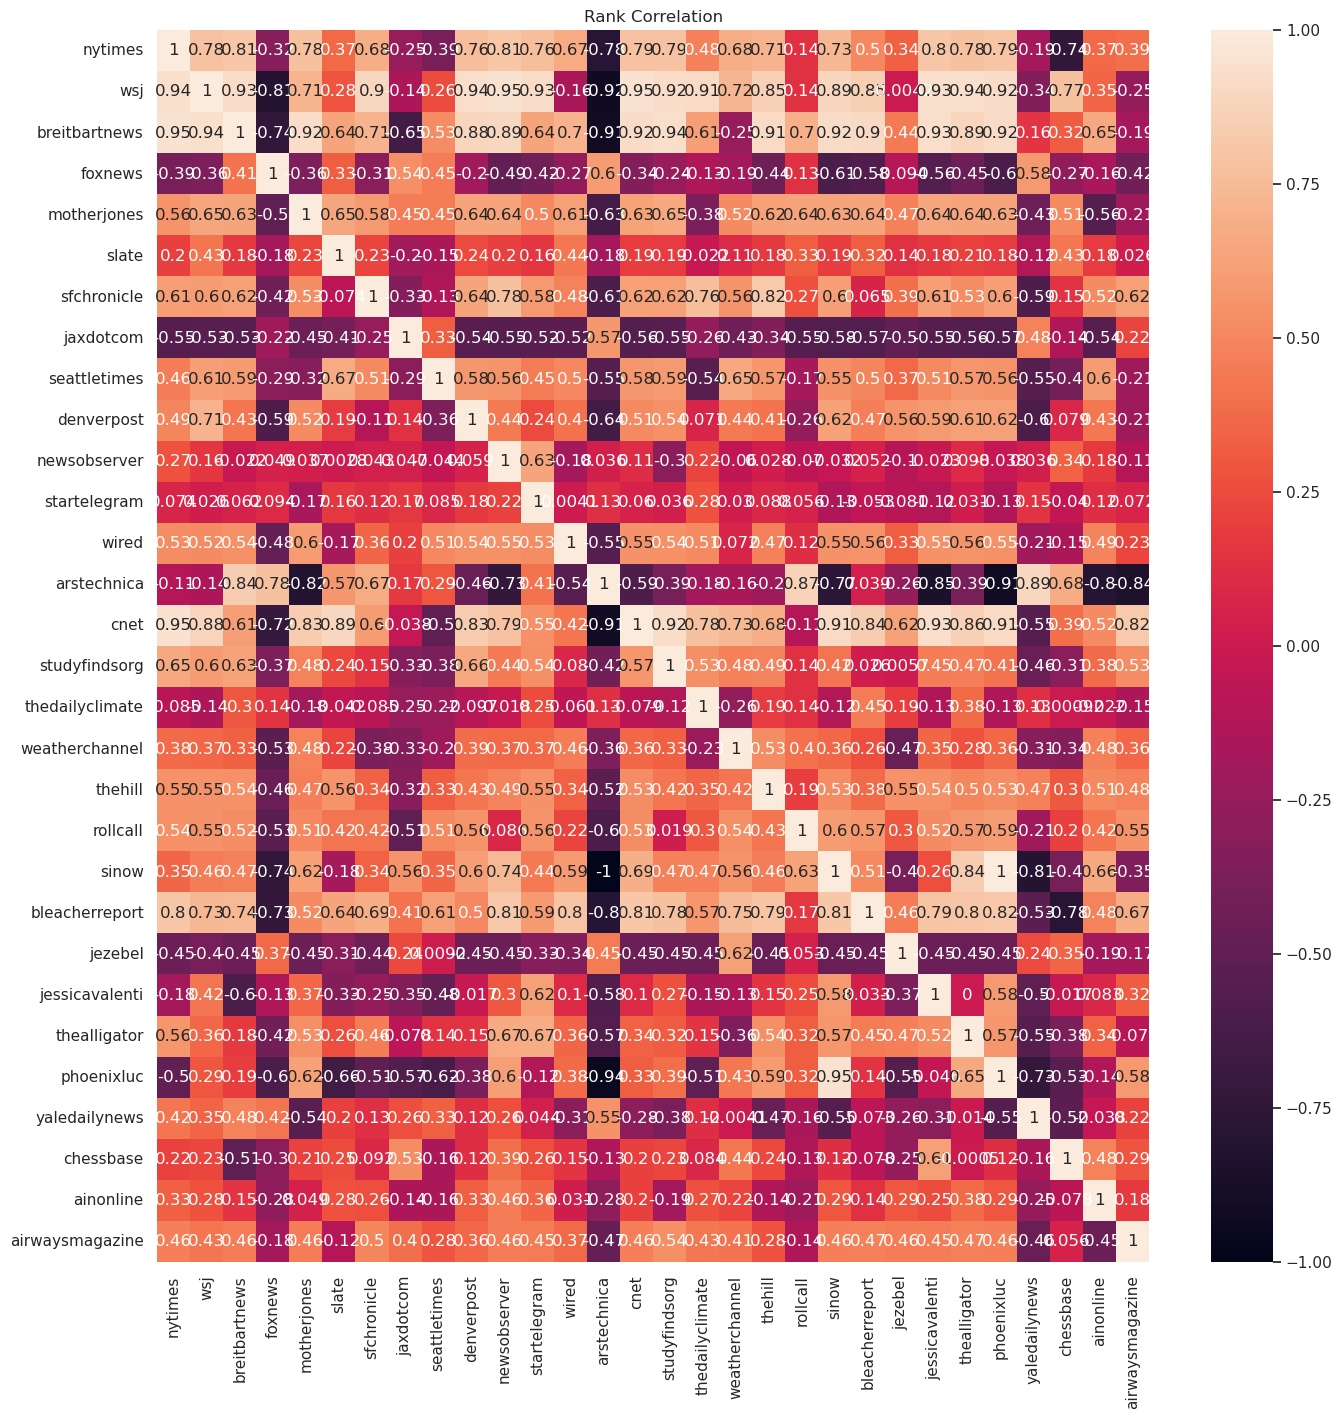

In [17]:
plt.figure(figsize=(16, 16))
sns.heatmap(corrs, xticklabels=ordered_deciders, yticklabels=ordered_deciders, annot=True)
plt.title("Rank Correlation")

In [18]:
set_agreement = np.zeros((len(deciders), len(deciders)))

for i, d1 in enumerate(tqdm(ordered_deciders)):
    for j, d2 in enumerate((ordered_deciders)):
        l1 = all_rankings[all_rankings.decider.eq(d1) & all_rankings.list_name.eq(f"outlet_{d1}")]
        l2 = all_rankings[all_rankings.decider.eq(d2) & all_rankings.list_name.eq(f"outlet_{d1}")]

        k = int(len(l1) * 0.2)
        topk_1 = set(l1[l1.article_rank.le(k)].article_idx)
        topk_2 = set(l2[l2.article_rank.le(k)].article_idx)
        set_agreement[i][j] = len(topk_1 & topk_2) / len(topk_1 | topk_2)
            

  0%|          | 0/30 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Top 20% Jaccard Similarity')

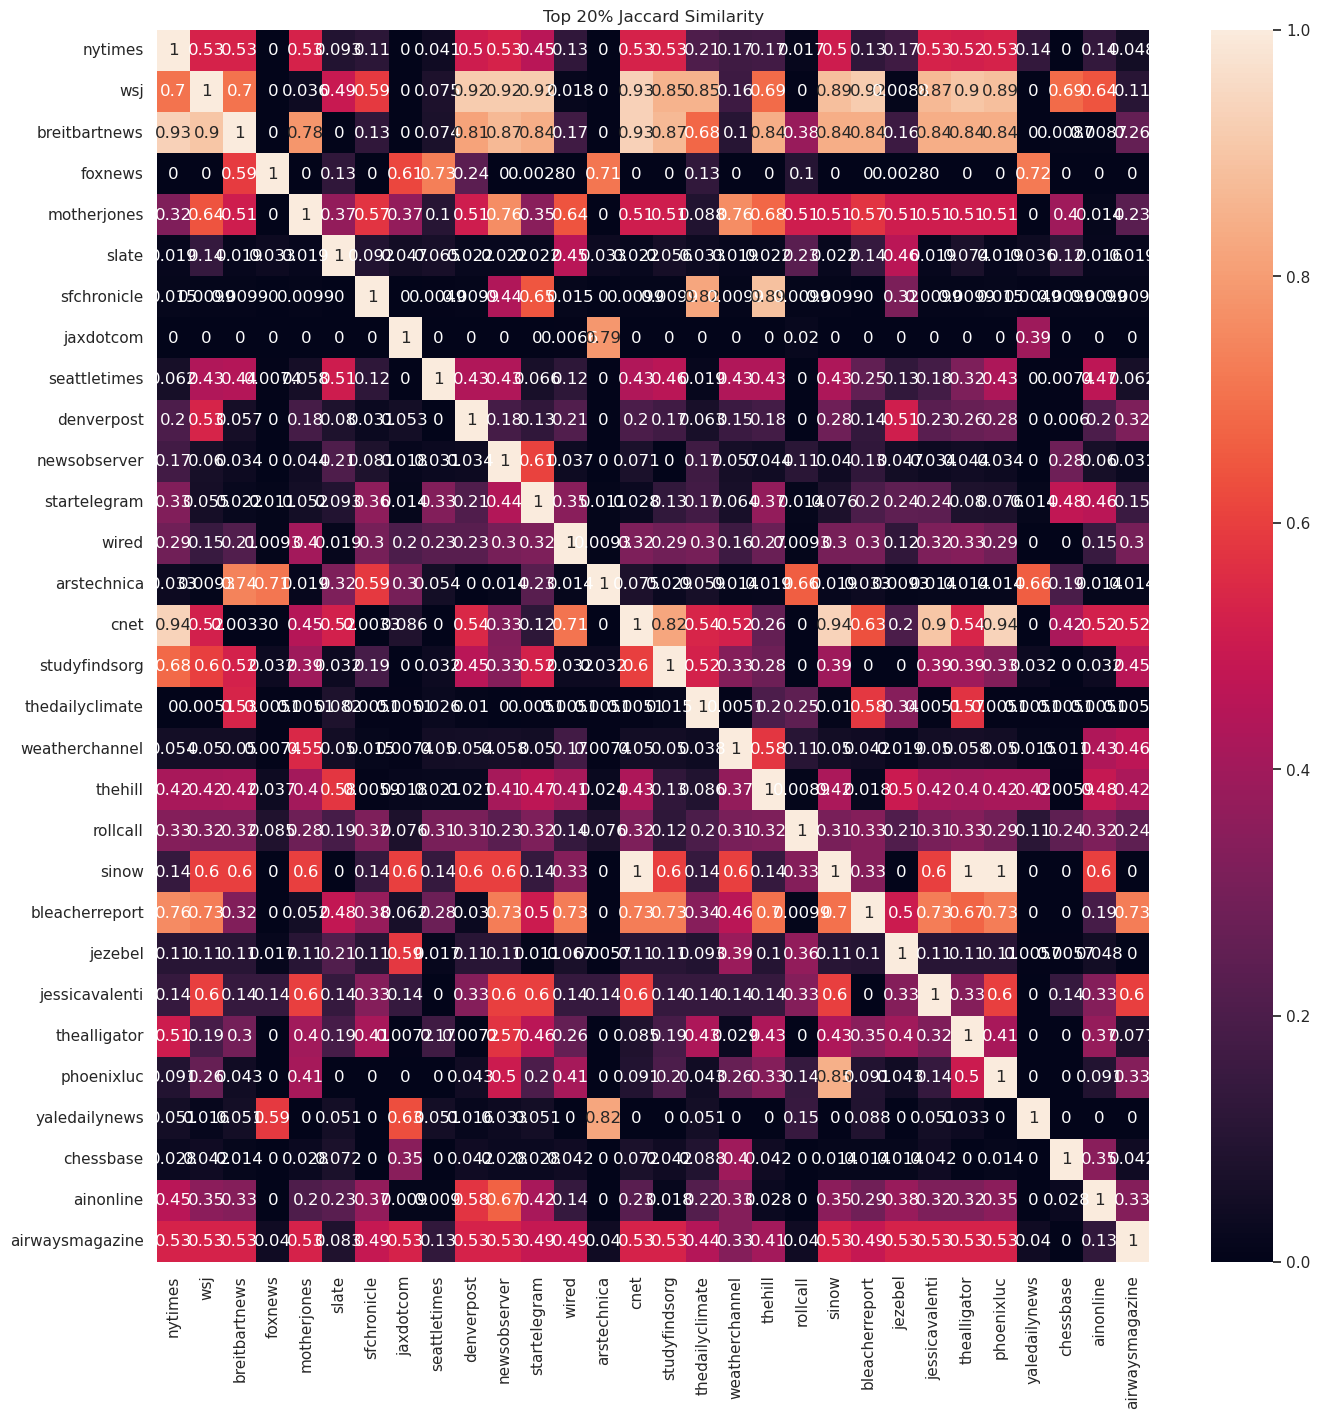

In [19]:
plt.figure(figsize=(16, 16))
sns.heatmap(set_agreement, xticklabels=ordered_deciders, yticklabels=ordered_deciders, annot=True)
plt.title("Top 20% Jaccard Similarity")

In [20]:
topn_corr = np.zeros((len(deciders), len(deciders)))

for i, d1 in enumerate(tqdm(ordered_deciders)):
    for j, d2 in enumerate((ordered_deciders)):
        l1 = all_rankings[all_rankings.decider.eq(d1) & all_rankings.list_name.eq(f"outlet_{d1}")].set_index("article_idx")
        l2 = all_rankings[all_rankings.decider.eq(d2) & all_rankings.list_name.eq(f"outlet_{d1}")].set_index("article_idx")

        k = int(len(l1) * 0.2)
        topk = l1[l1.article_rank.le(k)].index

        topn_corr[i][j] = stats.kendalltau(l1.loc[topk].article_rank, l2.loc[topk].article_rank).statistic
            

  0%|          | 0/30 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Top 20% Rank Corr')

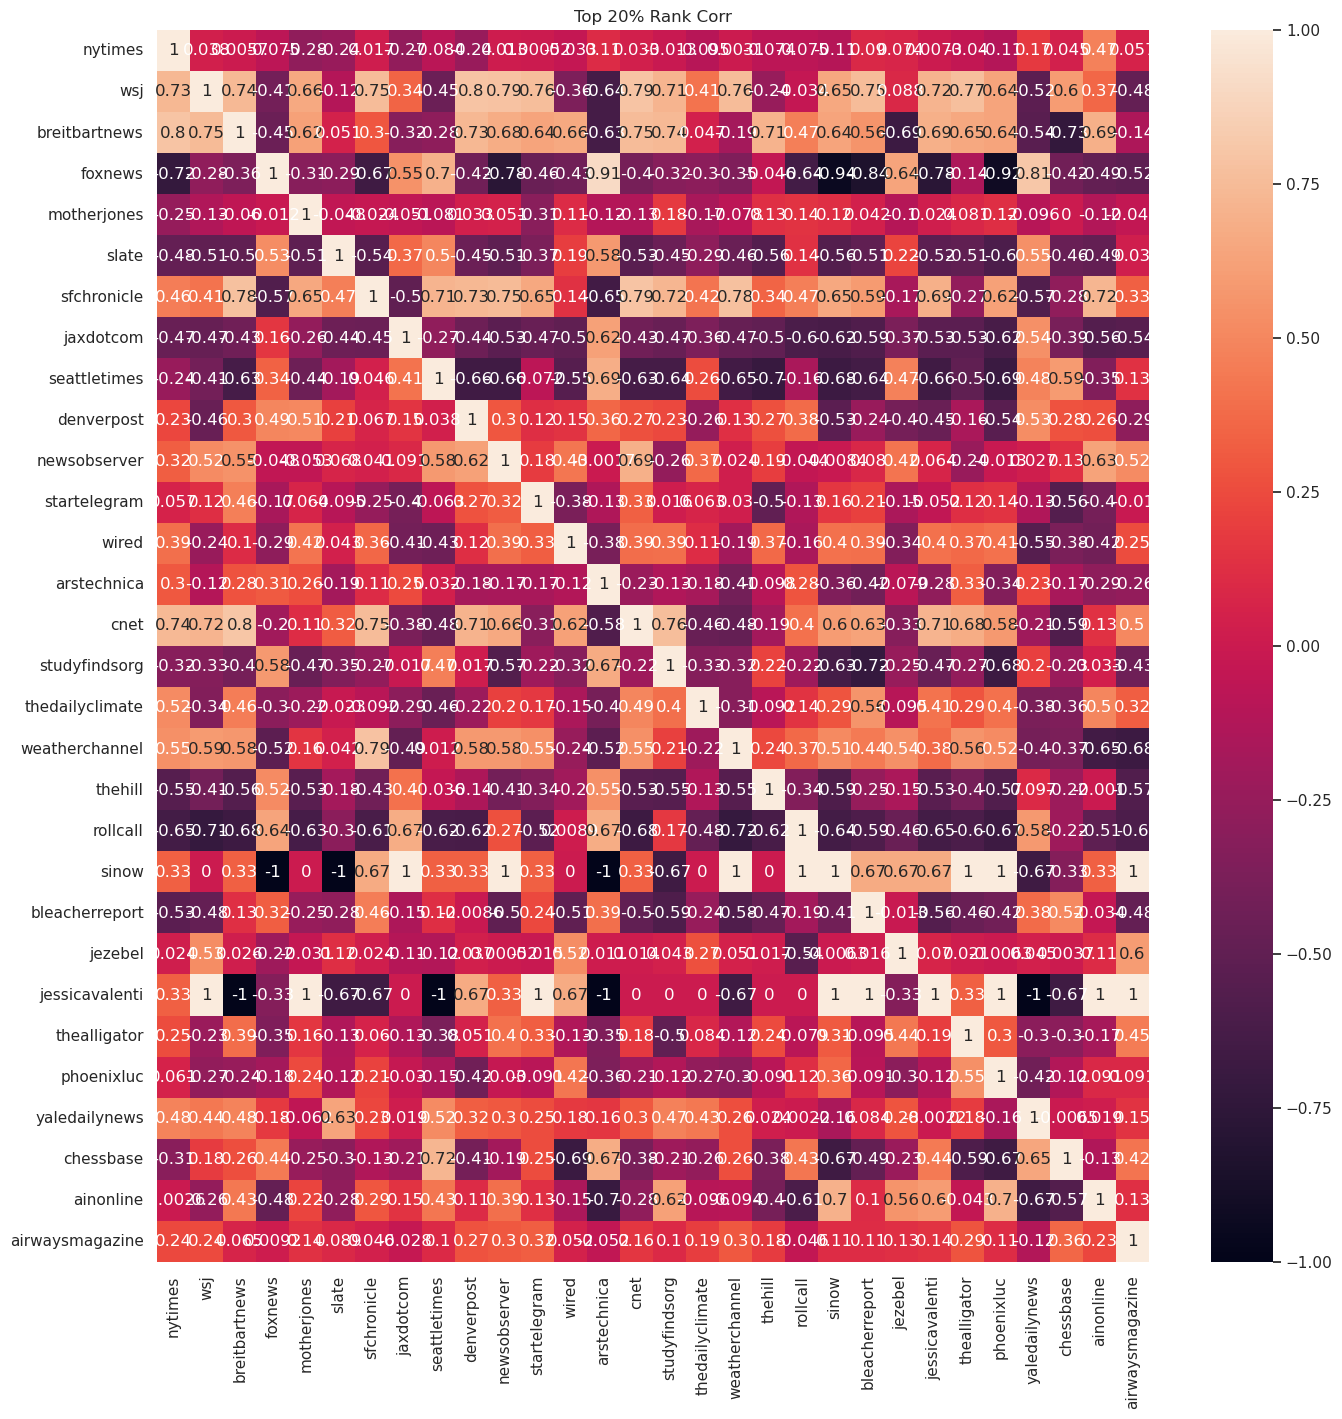

In [21]:
plt.figure(figsize=(16, 16))
sns.heatmap(topn_corr, xticklabels=ordered_deciders, yticklabels=ordered_deciders, annot=True)
plt.title("Top 20% Rank Corr")

In [22]:
bottn_corr = np.zeros((len(deciders), len(deciders)))

for i, d1 in enumerate(tqdm(ordered_deciders)):
    for j, d2 in enumerate((ordered_deciders)):
        l1 = all_rankings[all_rankings.decider.eq(d1) & all_rankings.list_name.eq(f"outlet_{d1}")].set_index("article_idx")
        l2 = all_rankings[all_rankings.decider.eq(d2) & all_rankings.list_name.eq(f"outlet_{d1}")].set_index("article_idx")

        k = len(l1) - int(len(l1) * 0.2)
        topk = l1[l1.article_rank.ge(k)].index
        bottn_corr[i][j] = stats.kendalltau(l1.loc[topk].article_rank, l2.loc[topk].article_rank).statistic
            

  0%|          | 0/30 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Bottom 20% Rank Corr')

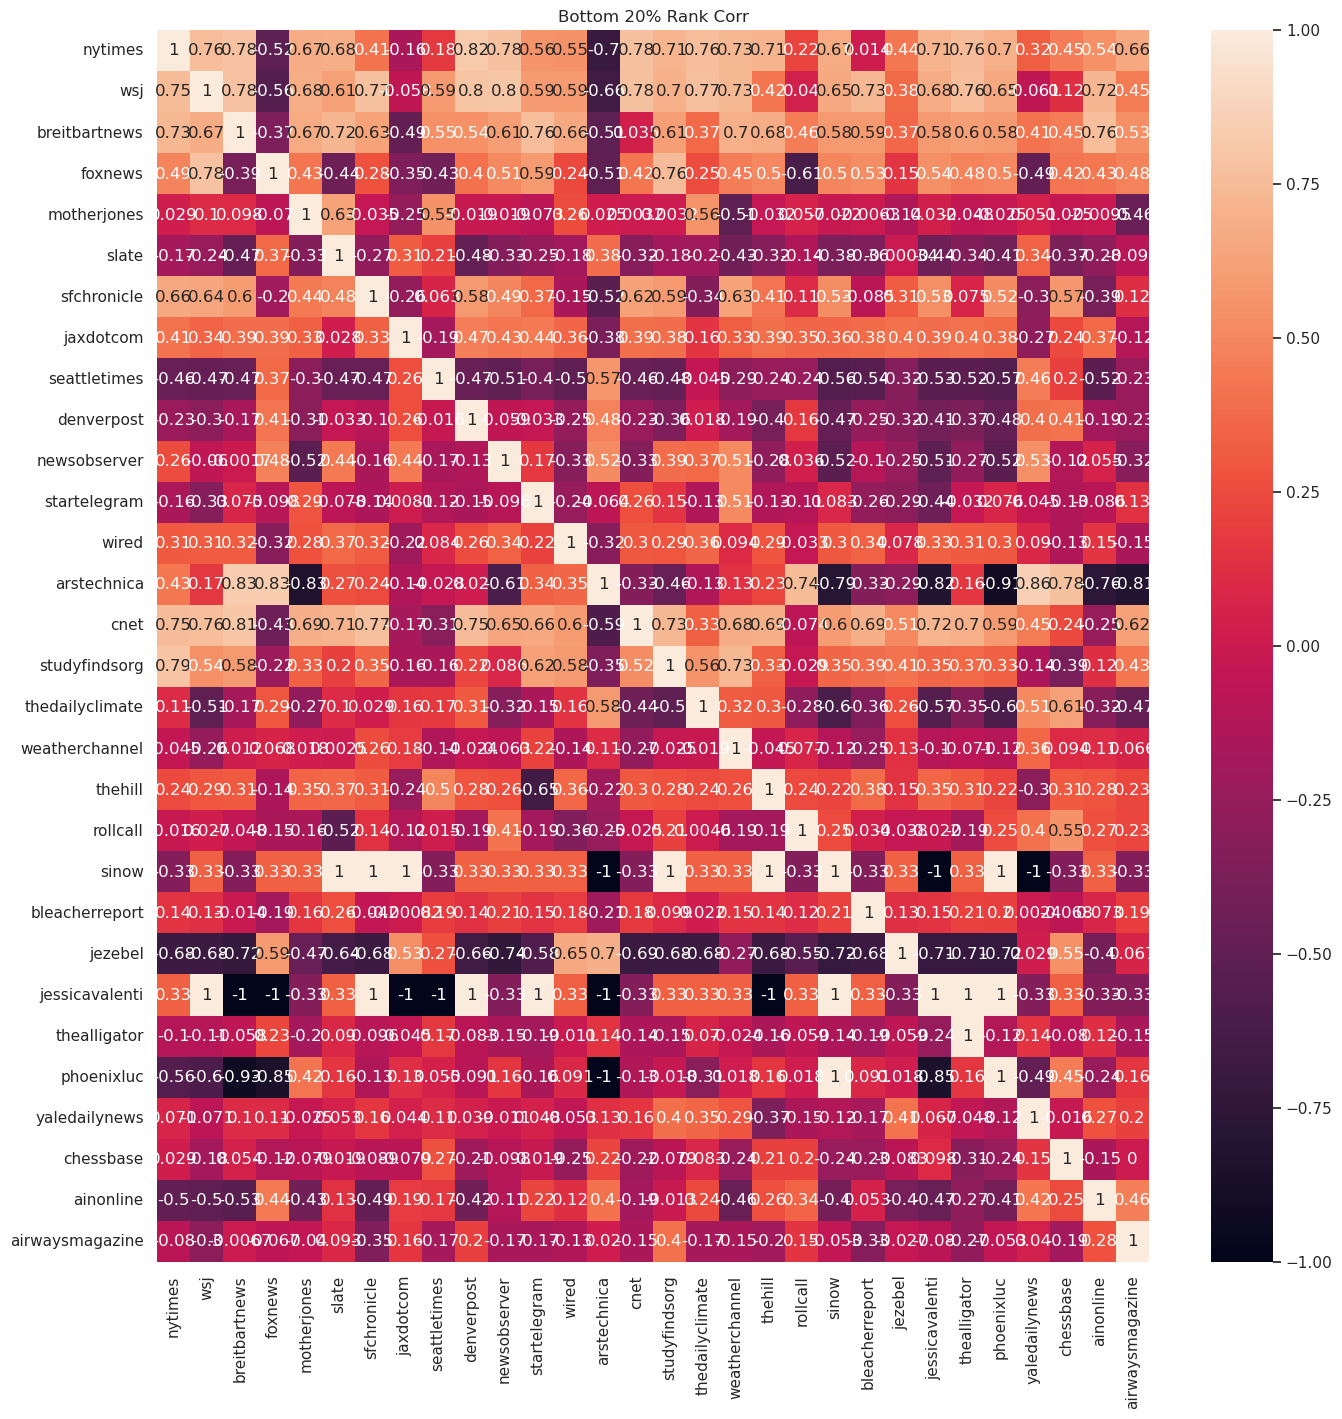

In [23]:
plt.figure(figsize=(16, 16))
sns.heatmap(bottn_corr, xticklabels=ordered_deciders, yticklabels=ordered_deciders, annot=True)
plt.title("Bottom 20% Rank Corr")

## Other plots

In [24]:
long_df = pd.DataFrame(corrs, index=ordered_deciders, columns=ordered_deciders).reset_index(names="source").melt(id_vars="source", var_name="decider")

<Axes: xlabel='value', ylabel='source'>

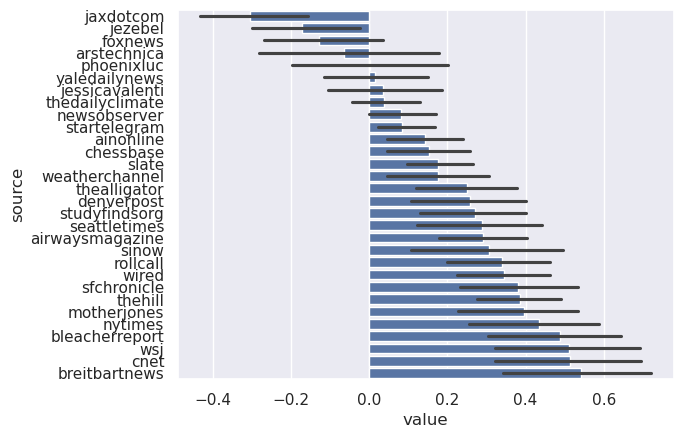

In [25]:
sns.barplot(data=long_df, x="value", y="source", order=long_df.groupby("source").value.mean().sort_values().index)

<Axes: xlabel='value', ylabel='decider'>

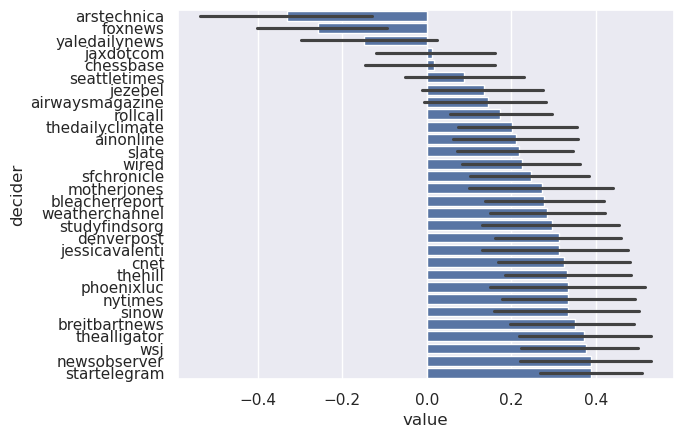

In [26]:
sns.barplot(data=long_df, x="value", y="decider", order=long_df.groupby("decider").value.mean().sort_values().index)

<Axes: >

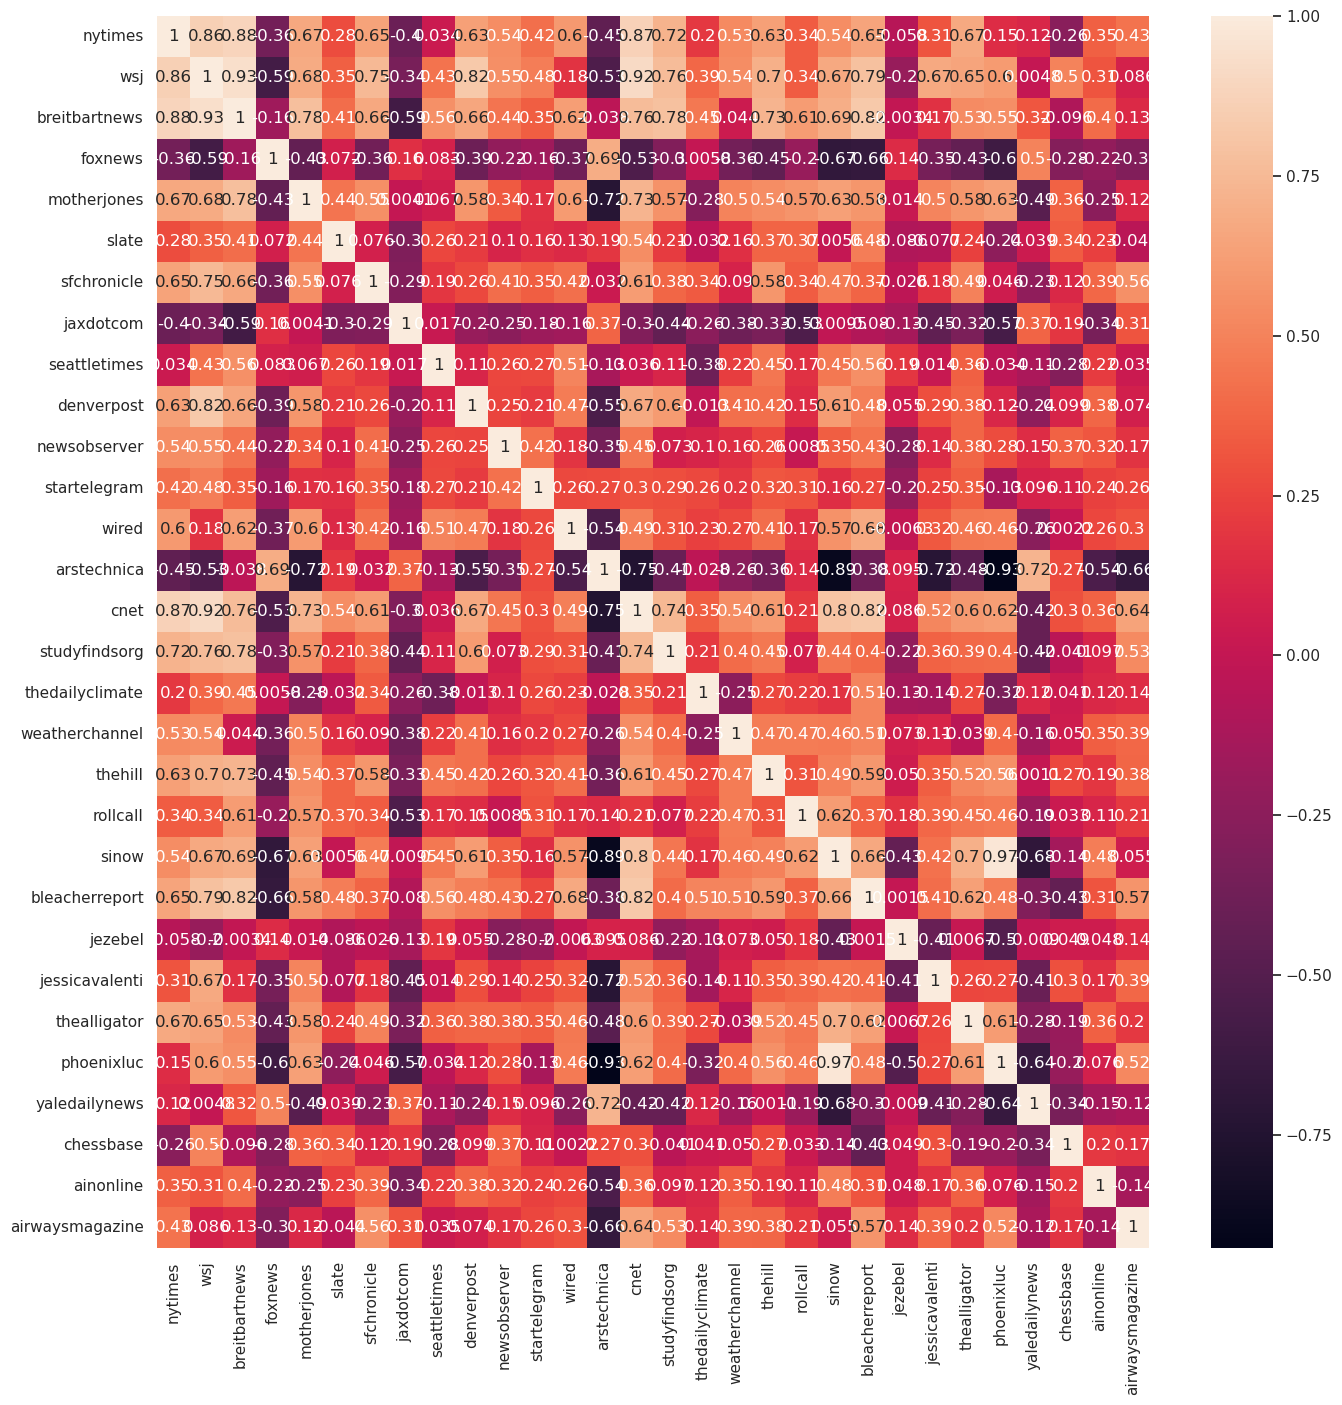

In [27]:
plt.figure(figsize=(16, 16))
sns.heatmap((corrs + corrs.T)/2, xticklabels=ordered_deciders, yticklabels=ordered_deciders, annot=True)

<Axes: >

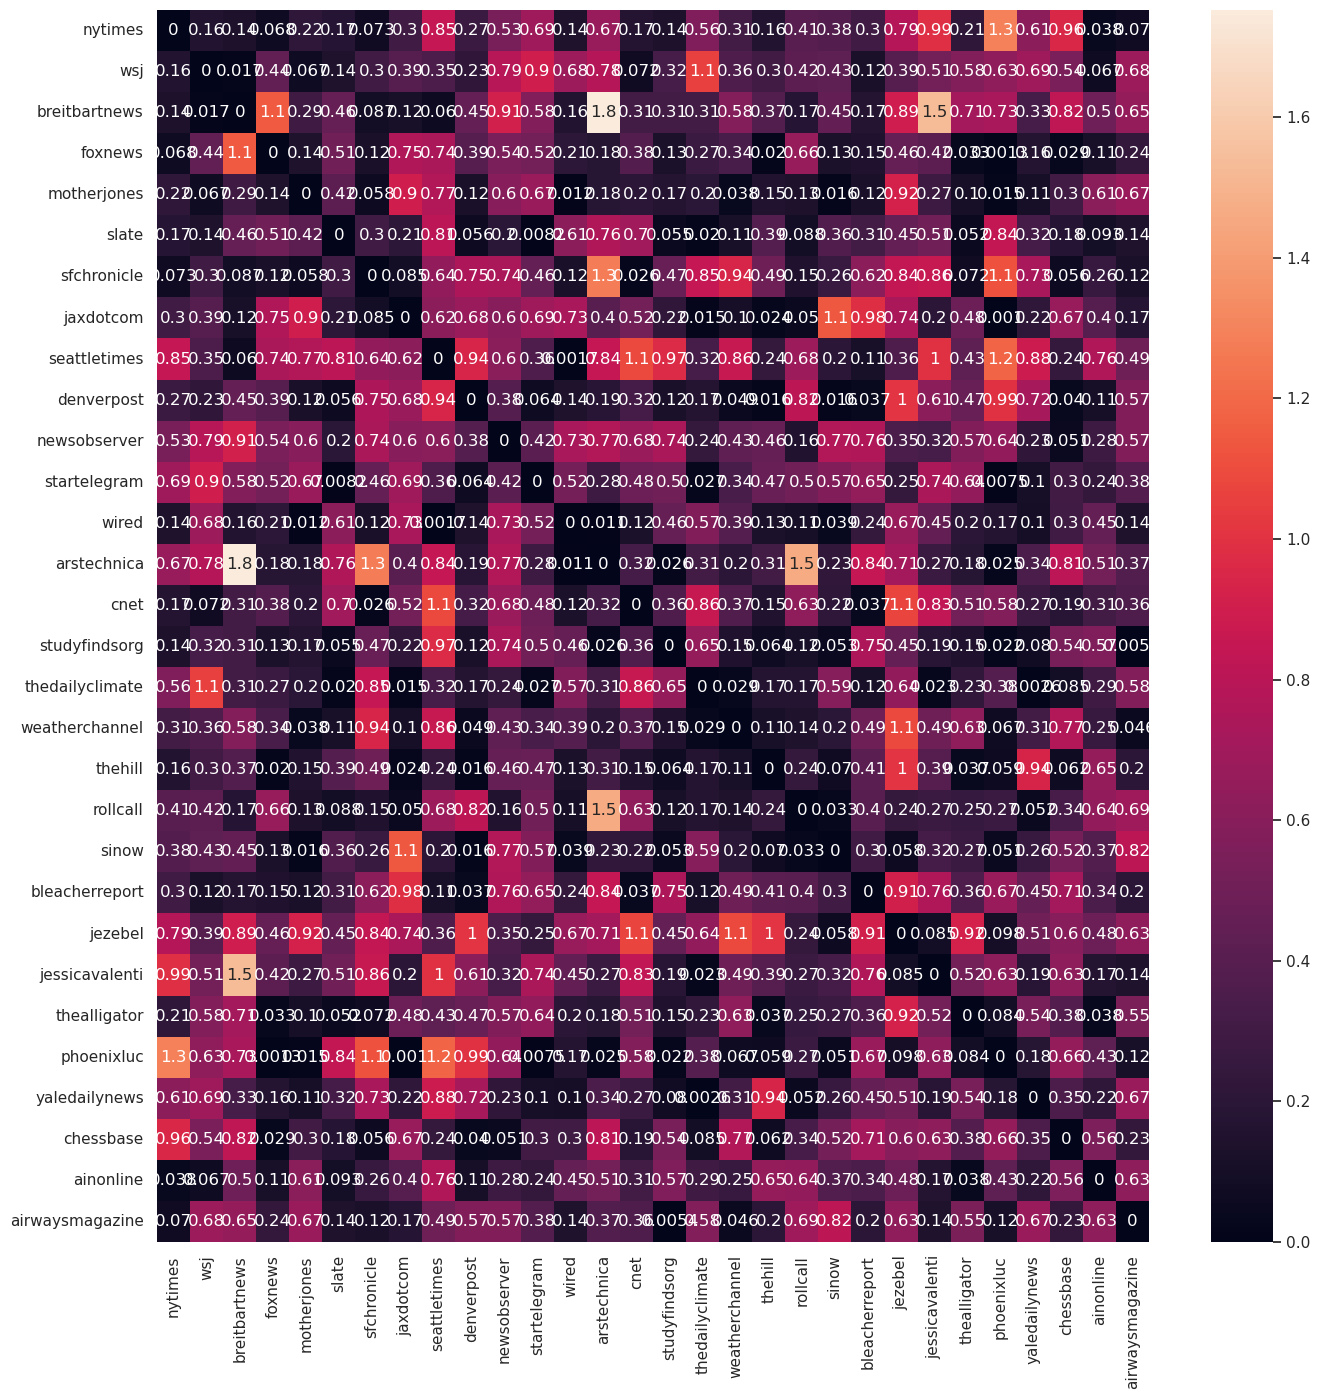

In [28]:
plt.figure(figsize=(16, 16))
sns.heatmap(np.abs(corrs - corrs.T), xticklabels=ordered_deciders, yticklabels=ordered_deciders, annot=True)

In [29]:
# sanity check the average X / Y distribution differences btw highest and lowest ranked articles
for d in ordered_deciders:
    l = all_rankings[all_rankings.decider.eq(d) & all_rankings.list_name.eq(f"outlet_{d}")]
    k = int(len(l1) * 0.2)
    top = l[l.article_rank.le(k)]
    bottom = l[l.article_rank.gt(len(l1) - k)]
    print(d)
    print(stats.ttest_ind(top.x, bottom.x, alternative="less"))
    print(stats.ttest_ind(top.y, bottom.y, alternative="less"))
    # sns.displot(data = l, x="x", hue=l.article_rank > k)

nytimes
TtestResult(statistic=np.float64(-2.834112755261677), pvalue=np.float64(0.0024275689770156443), df=np.float64(359.0))
TtestResult(statistic=np.float64(-0.4460175480128881), pvalue=np.float64(0.327926724165872), df=np.float64(359.0))
wsj
TtestResult(statistic=np.float64(-2.2792579895141345), pvalue=np.float64(0.011538282049850614), df=np.float64(495.0))
TtestResult(statistic=np.float64(0.2562296421024221), pvalue=np.float64(0.6010600139975033), df=np.float64(495.0))
breitbartnews
TtestResult(statistic=np.float64(-1.3644160458682408), pvalue=np.float64(0.08694504374057137), df=np.float64(211.0))
TtestResult(statistic=np.float64(0.48972914625868774), pvalue=np.float64(0.6875828280573796), df=np.float64(211.0))
foxnews
TtestResult(statistic=np.float64(-0.3975190721823647), pvalue=np.float64(0.34554415322059917), df=np.float64(819.0))
TtestResult(statistic=np.float64(-0.39579343976302644), pvalue=np.float64(0.3461802485316448), df=np.float64(819.0))
motherjones
TtestResult(statistic

/tmp/ipykernel_102252/4231385419.py:8: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  print(stats.ttest_ind(top.x, bottom.x, alternative="less"))
/tmp/ipykernel_102252/4231385419.py:9: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  print(stats.ttest_ind(top.y, bottom.y, alternative="less"))


thehill
TtestResult(statistic=np.float64(-0.12071673575911192), pvalue=np.float64(0.45197346797701515), df=np.float64(769.0))
TtestResult(statistic=np.float64(-2.311382522155207), pvalue=np.float64(0.010537629871042146), df=np.float64(769.0))
rollcall
TtestResult(statistic=np.float64(-2.403998969341937), pvalue=np.float64(0.008491157556517036), df=np.float64(238.0))
TtestResult(statistic=np.float64(-6.908085641892714), pvalue=np.float64(2.226390422317784e-11), df=np.float64(238.0))
sinow
TtestResult(statistic=np.float64(nan), pvalue=np.float64(nan), df=np.float64(nan))
TtestResult(statistic=np.float64(nan), pvalue=np.float64(nan), df=np.float64(nan))
bleacherreport
TtestResult(statistic=np.float64(-1.9051130996408987), pvalue=np.float64(0.029216963423549788), df=np.float64(172.0))
TtestResult(statistic=np.float64(0.4279531324689957), pvalue=np.float64(0.6653896981950759), df=np.float64(172.0))
jezebel
TtestResult(statistic=np.float64(-2.173525730287733), pvalue=np.float64(0.01519785085

# In/out-group

In [30]:
for group in groups:
    in_group = groups[group]
    out_group = [x for x in ordered_deciders if x not in in_group]
    ingroup_idx = list(itertools.permutations([ordered_deciders.index(i) for i in in_group], 2))
    outgroup_idx = list(itertools.permutations([ordered_deciders.index(i) for i in out_group], 2))
    print(group)
    print("in", corrs[ingroup_idx].mean())
    print("out", corrs[outgroup_idx].mean())

center
in 0.4732480627217524
out 0.1888445404496014
Right wing
in 0.2070048916702012
out 0.2078619098104265
Left wing
in 0.2859821252362779
out 0.20222067884142098
Local news
in 0.13078726148010208
out 0.2270591537146555
tech
in 0.26515382048168273
out 0.20143265913286285
Science
in 0.16127636808208926
out 0.21297459828837317
Politics
in 0.3626291751505374
out 0.19674588956183103
Sports
in 0.3979711315851642
out 0.1942214641022148
Feminist
in -0.06857288481141692
out 0.22754603670197066
Student
in 0.08882401694330577
out 0.22102485952601578
Chess
in nan
out 0.20974260554999263
Aviation
in 0.21776218622145432
out 0.2070935316281941


/tmp/ipykernel_102252/607997013.py:7: RuntimeWarning: Mean of empty slice.
  print("in", corrs[ingroup_idx].mean())
/home/naitian/news-homepages/.pixi/envs/default/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [31]:
for group in groups:
    in_group = groups[group]
    out_group = [x for x in ordered_deciders if x not in in_group]
    ingroup_idx = list(itertools.permutations([ordered_deciders.index(i) for i in in_group], 2))
    outgroup_idx = list(itertools.permutations([ordered_deciders.index(i) for i in out_group], 2))
    print(group)
    print("in", set_agreement[ingroup_idx].mean())
    print("out", set_agreement[outgroup_idx].mean())

center
in 0.4090324087947214
out 0.2442842634575601
Right wing
in 0.33254003793931086
out 0.2497480042329466
Left wing
in 0.2713667064298184
out 0.254117527912196
Local news
in 0.16349523665995908
out 0.2782105322683905
tech
in 0.288306855313532
out 0.25159643068372334
Science
in 0.18341790143704692
out 0.2632507588922217
Politics
in 0.29072703816052614
out 0.2527346470742883
Sports
in 0.41857104642695797
out 0.24360293219811466
Feminist
in 0.23207569957088367
out 0.25692402840212
Student
in 0.19779748384749699
out 0.26165302751328273
Chess
in nan
out 0.2608563776850546
Aviation
in 0.33333546823408106
out 0.24969118778332008


/tmp/ipykernel_102252/466771861.py:7: RuntimeWarning: Mean of empty slice.
  print("in", set_agreement[ingroup_idx].mean())


In [32]:
for group in groups:
    in_group = groups[group]
    out_group = [x for x in ordered_deciders if x not in in_group]
    ingroup_idx = list(itertools.permutations([ordered_deciders.index(i) for i in in_group], 2))
    outgroup_idx = list(itertools.permutations([ordered_deciders.index(i) for i in out_group], 2))
    print(group)
    print("in", (corrs + corrs.T)[ingroup_idx].mean())
    print("out", (corrs + corrs.T)[outgroup_idx].mean())

center
in 0.8293099064297434
out 0.38605952511447145
Right wing
in 0.2542887633419263
out 0.4271324639064583
Left wing
in 0.5311044292839346
out 0.4073599163391721
Local news
in 0.3704217777764008
out 0.42690649372526185
tech
in 0.33810905460525276
out 0.42422071674996037
Science
in 0.4219981088216326
out 0.41489971072591814
Politics
in 0.6149626559717115
out 0.4013700430043309
Sports
in 0.7046298259953263
out 0.3949652451455013
Feminist
in 0.1554960978234903
out 0.434189082872061
Student
in 0.2754497118327776
out 0.431182865946902
Chess
in nan
out 0.42415382910514976
Aviation
in 0.39583819695984185
out 0.4170217900766072


/tmp/ipykernel_102252/1698723427.py:7: RuntimeWarning: Mean of empty slice.
  print("in", (corrs + corrs.T)[ingroup_idx].mean())
